# Semi-supervised Machine Learning Implementations for Human TCR–epitope Interaction Modelling

In [1]:
# necessary setting to render plotly on GitHub
import plotly.io as pio
pio.renderers.default = "browser"

%matplotlib inline
# standard imports
import numpy as np
import pandas as pd
import os
import random
import time
import warnings

# classifiers
import sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
# semisupervised
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import LabelPropagation


# training and performance analysis
from sklearn.utils import shuffle
from sklearn import ensemble, feature_extraction, metrics, pipeline, preprocessing, model_selection
from sklearn.inspection import permutation_importance
from math import floor, log, e
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
import collections
import joblib

# biology
from pyteomics import electrochem, mass, parser

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns



# data location directory
base_dir = "semi_super_data/"
results_dir = 'Results/'

### Feature generation
#### as proposed and elaborated for the already developed [TCR-Classifier](https://github.com/bittremieux/TCR-Classifier/blob/master/tcr_classifier_v2.ipynb)

In [2]:
# physico-chemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

physchem_properties = {'basicity': basicity, 'hydrophobicity': hydrophobicity,
                       'helicity': helicity, 'mutation stability': mutation_stability}

#### Encodings of the V- and J-genes and -families removed as not relevant for this study at this time

In [3]:
def compute_features(data, gene_inclusion = []):

    """
    Creates feature vector representations for each TCR beta sequence in a pandas `DataFrame`.
    
    Sequences are turned into feature vectors based on the physicochemical properties of the CDR3 sequence.
    
    Args:
        - data: The pandas `DataFrame` containing TCR beta sequences.
        
    Returns:
        A pandas `DataFrame` in which rows contain feature information on a TCR beta sequence.
    """
    
    features_list = []
    
    ##### new data features
    # one-hot encode V- and J-genes and -families
    try:
        if gene_inclusion:
            onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
            features_list.append(pd.DataFrame(
                onehot_encoder.fit_transform(data[gene_inclusion].to_dict(orient='records')),
                columns=onehot_encoder.feature_names_))
    except KeyError as e:
        print('Missing gene information')
        pass
    #####
    
    
    
    # sequence length
    features_list.append(data['cdr3'].apply(lambda sequence: parser.length(sequence)).to_frame()
                         .rename(columns={'cdr3': 'length'}))

    # number of occurences of each amino acid
    aa_counts = pd.DataFrame.from_records(
        [parser.amino_acid_composition(sequence) for sequence in data['cdr3']]).fillna(0)
    aa_counts.columns = ['{} count'.format(column) for column in aa_counts.columns]
    features_list.append(aa_counts)

    # average physico-chemical properties
    for prop_name, prop_lookup in physchem_properties.items():
        features_list.append(data['cdr3'].apply(
            lambda sequence: np.mean(list(prop_lookup[aa] for aa in sequence)))
                               .to_frame().rename(columns={'cdr3': 'average {}'.format(prop_name)}))
    # peptide mass
    features_list.append(data['cdr3'].apply(
        lambda sequence: mass.fast_mass(sequence)).to_frame().rename(columns={'cdr3': 'mass'}))

    # pI
    features_list.append(data['cdr3'].apply(
        lambda sequence: electrochem.pI(sequence)).to_frame().rename(columns={'cdr3': 'pI'}))
    
    # positional features (i.e. localized at a specific amino acid position)
    pos_aa, pos_basicity, pos_hydro, pos_helicity, pos_mutation, pos_pI = [[] for _ in range(6)]
    for sequence in data['cdr3']:
        length = parser.length(sequence)
        start_pos = -1 * (length // 2)
        pos_range = list(range(start_pos, start_pos + length)) if length % 2 == 1 else\
                    list(range(start_pos, 0)) + list(range(1, start_pos + length + 1))

        pos_aa.append({'pos_{}_{}'.format(pos, aa): 1 for pos, aa in zip(pos_range, sequence)})
        pos_basicity.append({'pos_{}_basicity'.format(pos): basicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_hydro.append({'pos_{}_hydrophobicity'.format(pos): hydrophobicity[aa]
                          for pos, aa in zip(pos_range, sequence)})
        pos_helicity.append({'pos_{}_helicity'.format(pos): helicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_mutation.append({'pos_{}_mutation_stability'.format(pos): mutation_stability[aa]
                             for pos, aa in zip(pos_range, sequence)})
        
        pos_pI.append({'pos_{}_pI'.format(pos): electrochem.pI(aa)
                       for pos, aa in zip(pos_range, sequence)})

    features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_hydro).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_mutation).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
    
    return pd.concat(features_list, axis=1)

### Indeces creation for the subsequent CV training
##### ShuffleSplit utilized as a substitute for K-Fold CV due to the very low amount of labeled data available

In [4]:
def create_indices(y, pos_label=1, neg_label=0, n_splits=10, test_size=0.1, train_size=None, 
                   neg_multiplier=1, random_state=None):
    
    """
    Returns train and test indices for unbalanced data sets.
    
    Args:
        - y: The class labels.
        - pos_label: Label denoting the positive (small) class.
        - neg_label: Label denoting the negative (large) class.
        - n_splits: Number of splitting iterations.
        - test_size: The proportion of the positive samples to include in the test split.
        - train_size: The proportion of positive samples to include in the train split. If None,
                      the value is automatically set to the complement of the test size.
        - neg_multiplier: Number of times the negative set is larger than the positive set.
        - random_state: Seed used by the random number generator.
        
    Returns:
        A list of tuples of the train-test pairs for all the splits
    """
    
    np.random.seed(random_state)
    
    indices = []
    
    if train_size is None:
        train_size = 1 - test_size
    
    pos_idx = np.where(y == pos_label)[0]
    neg_idx = np.where(y == neg_label)[0]
    num_pos = len(pos_idx)
    
    pos_splitter = model_selection.ShuffleSplit(n_splits=n_splits,
                                                train_size=int(num_pos * train_size),
                                                test_size=int(num_pos * test_size),
                                                random_state=random_state)
    neg_splitter = model_selection.ShuffleSplit(n_splits=n_splits,
                                                train_size=int(num_pos * train_size * neg_multiplier),
                                                test_size=int(num_pos * test_size * neg_multiplier),
                                                random_state=random_state)
    
    
    for (pos_train_idx, pos_test_idx), (neg_train_idx, neg_test_idx) in\
            zip(pos_splitter.split(pos_idx), neg_splitter.split(neg_idx)):
        
        train_idx = np.concatenate((pos_idx[pos_train_idx], neg_idx[neg_train_idx]))
        test_idx = np.concatenate((pos_idx[pos_test_idx], neg_idx[neg_test_idx]))
        np.random.shuffle(train_idx)
        np.random.shuffle(test_idx)
        
        indices.append((train_idx,test_idx))
        
    return indices

In [5]:
def instantiate_models(random_state = None):
    
    """
    Create instances of the chosen models.
        
    Returns:
        A list of tuples. The first element is the initialized model, the second its name.
    """
    
    instances = [
        (RandomForestClassifier(n_estimators=100, class_weight = 'balanced', random_state = random_state), "RandomForest"),
        (GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, subsample = 0.5, random_state=random_state), "GradientBoosting"),
        (ExtraTreesClassifier(n_estimators=100, class_weight = 'balanced',random_state=random_state), "ExtraTrees"),
        (KNeighborsClassifier(n_neighbors = 7, weights = "distance"), "KNN"),
        (LogisticRegression(class_weight = 'balanced', random_state=random_state), "LogisticRegression"),
        (VotingClassifier(estimators=[
                                        ('rf', RandomForestClassifier(n_estimators=100, class_weight = 'balanced',random_state = random_state)),
                                        ('xts', ExtraTreesClassifier(n_estimators=100, class_weight = 'balanced',random_state=random_state)),
                                     ],
                                        voting='soft',
                         ), 'VotingClassifier'),
        ]
    
    return instances


In [6]:
def gene_entropy(gene_data):
    
    """
    Calculates entropy for the genetic data inputted.
    
    Args:
        - gene_data: the gene dataframe.
        
    Returns:
        A list of entropies.
    """
    entropies = []
    for col in gene_data.columns:
        entropy = 0
        value, counts = np.unique(gene_data[col], return_counts = True)
        #print('Max entropy: ', log(len(value),2))
        probs = counts / len(gene_data[col])
        for p in probs:
            entropy -= p * log(p, 2)
        print('Entropy for '+col+': %.3f' % (entropy))
        entropies.append(entropy)
    return entropies

In [7]:
def training(epitope = None, model_tuple = None, labeled_data = None, unlabeled_data = None,
             sampling = 'stratified', ttype = 'self', threshold = '_', random_state = None):
    
    """
    Returns train and test indices for unbalanced data sets.
    
    Args:
        - epitope: The epitope in use.
        - model_tuple: Tuple containing the model instance and its string name.
        - labeled_data: Labeled observations dataframe
        - unlabeled_data: Unlabeled observations dataframe
        - sampling: Sampling technique used for the current training iteration.
        - ttype: Training technique used for the current training iteration.
        - threshold: Threshold only used for the semi supervised training with a threshold imposed.
        - true_labels: Tuple containing the length of positive and negative true labels for semi supervised learning.
        - random_state: Seed used by the random number generator.
        
    Returns:
        A dictionary containing the performance metrics for the training iteration, to be appended to a 
        list with the rest of the results.
    """
    
    
    predictions = []
    predictions_proba = []
    permutation_importances = np.array([])
    permutation_importances_avg = np.array([])
    times = []
    model_name = model_tuple[1]
    training_results = []
    
    print('\nSampling type: ' + sampling + '\nTraining type: ' + ttype +
          '\nModel name: ' + model_name +'\nThreshold: ' + str(threshold) +'\n')
    
    np.random.seed(random_state)
    
    warnings.simplefilter('ignore')

    # Ratio of negative to positive labels
    multiplier = floor(labeled_data['y'].value_counts()[0]/labeled_data['y'].value_counts()[1])
    
    # index generation for the test-training split
    if sampling == 'stratified':
        index_generator = create_indices(labeled_data['y'], pos_label=1, neg_label=0, n_splits=5, test_size=0.2,
                                             neg_multiplier=multiplier, random_state=random_state)
        
    
    # extract genetic data
    gene_inclusion = [x for x in labeled_data.columns if (x.endswith('gene')) | (x.endswith('family'))]
    
    # iteration on the folds 
    for i, (train_idx, test_idx) in enumerate(index_generator):
        model = model_tuple[0]
        
        train_data, test_data = labeled_data.iloc[train_idx], labeled_data.iloc[test_idx]
        train_data.reset_index(drop = True, inplace = True)
        test_data.reset_index(drop = True, inplace = True)
            
        
        if ttype.startswith('supervised'):
            
            y_train,y_test = train_data['y'], test_data['y']
            y_train = pd.Series(map(int,y_train))
            y_test = pd.Series(map(int,y_test))
            
            combined = train_data.append(test_data)
            combined.reset_index(drop=True, inplace=True)
            
            combined_features = compute_features(combined, gene_inclusion)
            
            X_train = combined_features[:train_data.shape[0]]
            X_test = combined_features[train_data.shape[0]: train_data.shape[0] + test_data.shape[0]] 
            
            X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
            X_test, y_test = shuffle(X_test, y_test, random_state=random_state)
            
            
            # if model not trees scale
            if model_name not in ['GradientBoosting', 'ExtraTrees', 'RandomForest', 'VotingClassifier']:
                sc = StandardScaler()
                X_train = sc.fit_transform(X_train)
                X_test = sc.transform(X_test)
            
        else:
            
            unlabeled = unlabeled_data
            
            y_train, y_test = train_data['y'], test_data['y']
            y_train = pd.Series(map(int,list(y_train)))
            y_test = pd.Series(map(int,list(y_test)))
            
            combined = train_data.append(unlabeled.append(test_data))
            combined.reset_index(drop=True, inplace=True)
            
            combined_features = compute_features(combined, gene_inclusion)
            
            X_train = combined_features[:train_data.shape[0]]
            X_unlabeled = combined_features[train_data.shape[0]: train_data.shape[0] + unlabeled.shape[0]] 
            X_test = combined_features[train_data.shape[0] + unlabeled.shape[0]:]
            
            X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
            X_test, y_test = shuffle(X_test, y_test, random_state=random_state)
            
            # if model not trees scale
            if model_name not in ['GradientBoosting', 'ExtraTrees', 'RandomForest','VotingClassifier']:
                sc = StandardScaler()
                X_train = sc.fit_transform(X_train)
                X_unlabeled = sc.transform(X_unlabeled)
                X_test = sc.transform(X_test)
        
            if ttype.startswith('self'):

                if ttype.startswith('self_threshold'):
                    
                    if model_name not in ['GradientBoosting', 'LogisticRegression']:
                        
                        if model_name == 'VotingClassifier':
                            model_cal = VotingClassifier(estimators = [], voting='soft')
                            
                            for _, est in enumerate(model.estimators):
                                
                                if est[0] not in ['gradboost']:
                                    
                                    base_cal = CalibratedClassifierCV(est[1], cv = 3, method = 'isotonic', n_jobs = -1)
                                    base_cal.fit(X_train, y_train)
                                    
                                    model_cal.estimators.append((est[0],base_cal))
                                else:
                                    model_cal.estimators.append((est[0],est[1]))
                                
                        else:
                            model_cal = CalibratedClassifierCV(model, cv = 3, method = 'isotonic', n_jobs = -1)
                            model_cal.fit(X_train, y_train)
                            
                    else:
                        model_cal = model
                        
                    if model_name not in ['GradientBoosting', 'ExtraTrees', 'RandomForest','VotingClassifier']:
                        X_train = np.concatenate((X_train, X_unlabeled), axis=0)
                    else:
                        X_train = X_train.append(X_unlabeled)
        
                    y_train = y_train.append(pd.Series([-1] * X_unlabeled.shape[0]))
                    model = SelfTrainingClassifier(model_cal, max_iter = 5, criterion = 'threshold', threshold = threshold, verbose = 0)

        
        start = time.time()
        
        if ttype.startswith('self'):
            model.fit(X_train, y_train)
            data = pd.DataFrame()
            data['y_before'] = y_train
            data['y_after'] = model.transduction_
            
            
        elif ttype.startswith('supervised'):
            model.fit(X_train, y_train)
            
        end = time.time()
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
         
        times.append(end - start)  
        predictions.append((y_test, y_pred))
        predictions_proba.append((y_test, y_pred_proba))
        print(sklearn.metrics.confusion_matrix(y_test,y_pred))
        
        
        # Permutation importances require a long time to be produced
        # Remove comments only when needed
        ##########
        #per = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=random_state, n_jobs=-1)
        #if permutation_importances_avg.size == 0:
        #    permutation_importances_avg = per.importances_mean
        #    permutation_importances = per.importances
        #else:
        #    permutation_importances_avg += per.importances_mean
        #    permutation_importances += per.importances
        ############################
        fold_results = {'epitope' : epitope, 'model' : model_name,
                       'training_type' : ttype, 'threshold' : threshold, 'fold': i+1,
                       'balanced_accuracy' : metrics.balanced_accuracy_score(y_test, y_pred),
                       'auc' : metrics.roc_auc_score(y_test, y_pred_proba),
                       'avg_precision' : metrics.average_precision_score(y_test, y_pred_proba),
                       'brier_score' : metrics.brier_score_loss(y_test, y_pred_proba)}
        training_results.append(fold_results)
        ############################
        
    accuracy_mean, accuracy_std, recall_mean, recall_std, f1_mean, f1_std, auc_mean, auc_std, avg_precision_mean, avg_precision_std, brier_score_mean, brier_score_std = performance_analysis(predictions, predictions_proba)
    training_specs = {'epitope' : epitope, 'model' : model_name, 'sampling' : sampling,
           'training_type' : ttype, 'threshold' : threshold, 'avg_training time' : np.mean(times),
           'balanced_accuracy_mean' : accuracy_mean, 'balanced_accuracy_std' : accuracy_std,
           'recall_mean' : recall_mean, 'recall_std' : recall_std,
           'f1_mean' : f1_mean, 'f1_std' : f1_std,
           'auc_mean' : auc_mean, 'auc_std' : auc_std,
           'avg_precision_mean' : avg_precision_mean, 'avg_precision_std' : avg_precision_std,
            'brier_score_mean' : brier_score_mean, 'brier_score_std': brier_score_std}
    
    
    # Permutation importances require a long time to be produced
    # Remove comments only when needed
    #######
    #sorted_idx = permutation_importances_avg.argsort()
    #sorted_idx = sorted_idx[::-1]
    #sorted_idx = sorted_idx[:10]
    #fig, ax = plt.subplots()
    #ax.boxplot(permutation_importances[sorted_idx][::-1].T, vert=False, labels=X_train.columns[sorted_idx][::-1])
    #if threshold == '_':
    #    ax.set_title(epitope + ' ' + model_name + ' ' + ttype)
    #else:
    #    ax.set_title(epitope + ' ' + model_name + ' ' + ttype + str(threshold))
    #fig.tight_layout()
    #fig.savefig(results_dir + epitope + '_' + model_name + '_' + ttype + str(threshold) + '.png', dpi=800)
    #plt.show()
    print('Accuracy: %.3f, AUC: %.3f, AvgPrec: %.3f' % (accuracy_mean, auc_mean, avg_precision_mean))
    
    #return training_specs
    return training_results
        

In [8]:
def gene_study(labeled_data, epitope):
    
    positives = labeled_data[labeled_data['y'] == 1]
    negatives = labeled_data[labeled_data['y'] == 0]
    positives = positives[['V_gene', 'J_gene', 'V_family', 'J_family']]
    negatives = negatives[['V_gene', 'J_gene', 'V_family', 'J_family']]

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('V_gene', 'J_gene', 'V_family', 'J_family'))
    
    for i, col in enumerate(positives.columns):
        if col == 'V_gene':
            n_row = 1
            n_col = 1
            flag = False
        elif col == 'V_family':
            n_row = 2
            n_col = 1
            flag = True
        elif col == 'J_gene':
            n_row = 1
            n_col = 2
            flag = False
        elif col == 'J_family':
            n_row = 2
            n_col = 2
            flag = False
        positive_value_counts = (positives[col].value_counts()/positives.shape[0])[0:10].reset_index()
        positive_value_counts.columns = ['unique_values', 'counts']
        negative_value_counts = (negatives[col].value_counts()/negatives.shape[0]).reset_index()
        negative_value_counts.columns = ['unique_values', 'counts']
        negative_value_counts = negative_value_counts[negative_value_counts['unique_values'].isin(positive_value_counts['unique_values'])]

        fig.add_trace(go.Bar(
                            y=positive_value_counts['unique_values'],
                            x=positive_value_counts['counts'],
                            name='Positives',
                            marker_color='#0099C6',
                            legendgroup='group1',
                            showlegend=flag,
                            orientation='h'
                        ), row=n_row, col=n_col)
        fig.add_trace(go.Bar(
                            y=negative_value_counts['unique_values'],
                            x=negative_value_counts['counts'],
                            name='Negatives',
                            marker_color='#FFA15A',
                            legendgroup='group1',
                            showlegend=flag,
                            orientation='h'
                        ), row=n_row, col=n_col)

    # Here we modify the tickangle of the xaxis, resulting in rotated labels.
    fig.update_layout(yaxis_type='category', yaxis=dict(autorange="reversed"))
    fig.update_layout(yaxis2_type='category', yaxis2=dict(autorange="reversed"))
    fig.update_layout(yaxis3_type='category', yaxis3=dict(autorange="reversed"))
    fig.update_layout(yaxis4_type='category', yaxis4=dict(autorange="reversed"))
    
    fig.update_layout(height=700, width=800,
                      title_text='Gene distributions - '+ epitope)
    fig['layout']['xaxis']['title']='Gene category ratio'
    fig['layout']['xaxis2']['title']='Gene category ratio'
    fig['layout']['xaxis3']['title']='Gene category ratio'
    fig['layout']['xaxis4']['title']='Gene category ratio'
    #fig.write_image(results_dir + epitope +'/gene_distribution_' + epitope + '.png', height=700, width=800, scale = 4)
    #fig.show()
    
    

In [9]:
def performances_plots(predictions, predictions_proba, feature_importances, training_specs):
    import string
    
    
    f, axes = plt.subplots(3, 1, figsize=(6, 18))

    # AUC and average precision
    auc_mean = training_specs['auc_mean']
    auc_std = training_specs['auc_std']
    avg_precision_mean = training_specs['avg_precision_mean']
    avg_precision_std = training_specs['avg_precision_std']
    
    avg_precision_inverted_mean = np.mean([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                           for y_test, y_pred in predictions_proba])
    avg_precision_inverted_std = np.std([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                         for y_test, y_pred in predictions_proba])

    # mean and standard deviation of ROC and precision-recall curves
    interval = np.linspace(0, 1, 100)
    tprs, precisions, precisions_inverted = [], [], []
    for y_test, y_pred in predictions_proba:
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
        tprs.append(np.interp(interval, fpr, tpr))

        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        precisions.append(np.interp(interval, recall[::-1], precision))

        # inverted precision
        precision_inverted, recall_inverted, _ = metrics.precision_recall_curve(1 - y_test, 1 - y_pred)
        precisions_inverted.append(np.interp(interval, recall_inverted[::-1], precision_inverted))

    tpr_mean = np.mean(tprs, axis=0)
    tpr_mean[0], tpr_mean[-1] = 0.0, 1.0
    tpr_std = np.std(tprs, axis=0)
    precision_mean = np.mean(precisions, axis=0)
    precision_std = np.std(precisions, axis=0)
    precision_inverted_mean = np.mean(precisions_inverted, axis=0)
    precision_inverted_std = np.std(precisions_inverted, axis=0)


    # plot ROC curve
    ax = axes[0]
    ax.plot(interval, tpr_mean, label='AUROC = {:.2f} ± {:.2f}'.format(auc_mean, auc_std))
    ax.fill_between(interval, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.5)

    ax.plot([0, 1], [0, 1], 'k--')
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title(training_specs['epitope'])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    ax.legend(loc='lower right', frameon=True)
    
    ax.annotate(string.ascii_uppercase[0], xy=(-0.1,1.1), xycoords='axes fraction', textcoords='offset points',
                fontsize=16, xytext=(0, -15), weight='bold', ha='right', va='top')
    
    # plot precision-recall curve
    ax = axes[1]
    ax.plot(interval[::-1], precision_mean,
            label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_mean, avg_precision_std))
    ax.fill_between(interval[::-1], precision_mean - precision_std, precision_mean + precision_std, alpha=0.5)
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)
    
    ax.legend(loc='upper right', frameon=True)

    ax.annotate(string.ascii_uppercase[1], xy=(-0.1,1.1), xycoords='axes fraction', textcoords='offset points',
                fontsize=16, xytext=(0, -15), weight='bold', ha='right', va='top')
    
    # plot feature importances
    ax = axes[2]
    feat_import_s = pd.Series(feature_importances.mean(),
                              index=feature_importances.columns, name='Feature importances')
    
    significant_features = feat_import_s[feat_import_s > 0.01].sort_values(ascending=False)

    sns.barplot(x=significant_features.index.values, y=significant_features, palette='Blues_d', ax=ax)

    ax.set_xticklabels(significant_features.index.values, rotation='vertical', fontsize=12)
    
    ax.set_ylabel('Feature importance')
    
    ax.annotate(string.ascii_uppercase[2], xy=(-0.1,1.1), xycoords='axes fraction', textcoords='offset points',
                fontsize=16, xytext=(0, -15), weight='bold', ha='right', va='top')
    
    
    file_name = results_dir + training_specs['epitope'] + '/'
    for v in training_specs.values():
        if type(v) == str and v != '_':
            file_name+=v
            file_name+='_'
            
    file_name = file_name[:-1]   
    try:
        os.mkdir(results_dir + training_specs['epitope'])
    except:
        pass
    #plt.savefig(file_name + '.png', bbox_inches='tight', dpi=500)

### Performance values generated from the predictions

In [10]:
def performance_analysis(predictions, predictions_proba):
    
    """
    Returns train and test indices for unbalanced data sets.
    
    Args:
        - predictions: List of tuples. Each tuples contains test labels and labels predicted 
                       for each fold of cross validation.
        - predictions_proba: List of tuples. Each tuples contains test labels and probability of 
                       labels predicted for each fold of cross validation.
        
    Returns:
        Means and standard deviations of chosen performance metrics calculated across the folds.
    """
    
    # accuracy
    accuracy_mean = np.mean([metrics.balanced_accuracy_score(y_test, y_pred)
                             for y_test, y_pred in predictions])
    accuracy_std = np.std([metrics.balanced_accuracy_score(y_test, y_pred)
                           for y_test, y_pred in predictions])
    
    #print('Accuracy: %.3f (%.3f)' % (accuracy_mean, accuracy_std))
    
    # recall
    recall_mean = np.mean([metrics.recall_score(y_test, y_pred)
                             for y_test, y_pred in predictions])
    recall_std = np.std([metrics.recall_score(y_test, y_pred)
                           for y_test, y_pred in predictions])
    
    #print('Recall: %.3f (%.3f)' % (recall_mean, recall_std))
    
    # f1-score
    f1_mean = np.mean([metrics.f1_score(y_test, y_pred)
                             for y_test, y_pred in predictions])
    f1_std = np.std([metrics.f1_score(y_test, y_pred)
                           for y_test, y_pred in predictions])
    
    #print('F1_score: %.3f (%.3f)' % (f1_mean, f1_std))
    
    # AUC
    auc_mean = np.mean([metrics.roc_auc_score(y_test, y_pred)
                        for y_test, y_pred in predictions_proba])
    auc_std = np.std([metrics.roc_auc_score(y_test, y_pred)
                      for y_test, y_pred in predictions_proba])
    
    #print('AUC: %.3f (%.3f)' % (auc_mean, auc_std))
    
    # Average precision
    avg_precision_mean = np.mean([metrics.average_precision_score(y_test, y_pred)
                                  for y_test, y_pred in predictions_proba])
    avg_precision_std = np.std([metrics.average_precision_score(y_test, y_pred)
                                for y_test, y_pred in predictions_proba])
    
    
    # Brier score
    brier_score_mean = np.mean([metrics.brier_score_loss(y_test, y_pred)
                                  for y_test, y_pred in predictions_proba])
    brier_score_std = np.std([metrics.brier_score_loss(y_test, y_pred)
                                for y_test, y_pred in predictions_proba])
    
    #print('Avg Precision: %.3f (%.3f)' % (avg_precision_mean, avg_precision_std))
    return accuracy_mean, accuracy_std, recall_mean, recall_std, f1_mean, f1_std, auc_mean, auc_std, avg_precision_mean, avg_precision_std, brier_score_mean, brier_score_std


In [11]:
def main_cycle(base_dir, epitope, random_state=None):
    
    """
    Iterations of the core functions of the project, ending in the dump of the results.
    
    Args:
        - base_dir: Base directory of the project.
        - epitope: String denoting the epitope referred to for the cycle.
        - new_unlabeled: Unlabeled data obtained through scraping to be used across iterations.
        - random_state: Seed used by the random number generator.
        
    """
    
    np.random.seed(random_state)
    
    # Labeled and unlabeled data for the current epitope
    labeled_data = pd.read_csv(base_dir + epitope + '/labeled.csv')
    unlabeled_data = pd.read_csv(base_dir + epitope + '/unlabeled.csv')
    
    labeled_data.rename(columns={"CDR3_beta": "cdr3"}, inplace = True)
    labeled_data[['V_gene', 'J_gene', 'V_family', 'J_family']] = labeled_data[['V_gene', 'J_gene', 'V_family', 'J_family']].astype(str)
    labeled_data.drop(['score', 'antigen.epitope'], axis=1, inplace = True)
    labeled_data['V_gene'] = ['0' + x if len(x) == 1 else x for x in labeled_data['V_gene'].astype(str)]
    labeled_data['V_family'] = ['0' + x if len(x) == 1 else x for x in labeled_data['V_family'] .astype(str)]
    labeled_data['J_gene'] = ['0' + x if len(x) == 1 else x for x in labeled_data['J_gene'].astype(str)]
    labeled_data['J_family'] = ['0' + x if len(x) == 1 else x for x in labeled_data['J_family'].astype(str)]

    unlabeled_data.rename(columns={"CDR3_beta": "cdr3"}, inplace = True)
    unlabeled_data[['V_gene', 'J_gene', 'V_family', 'J_family']] = unlabeled_data[['V_gene', 'J_gene', 'V_family', 'J_family']].astype(str)
    unlabeled_data = unlabeled_data[['V_gene', 'J_gene', 'V_family', 'J_family', 'cdr3']]
    unlabeled_data['V_gene'] = ['0' + x if len(x) == 1 else x for x in unlabeled_data['V_gene'].astype(str)]
    unlabeled_data['V_family'] = ['0' + x if len(x) == 1 else x for x in unlabeled_data['V_family'] .astype(str)]
    unlabeled_data['J_gene'] = ['0' + x if len(x) == 1 else x for x in unlabeled_data['J_gene'].astype(str)]
    unlabeled_data['J_family'] = ['0' + x if len(x) == 1 else x for x in unlabeled_data['J_family'].astype(str)]

    unlabeled_data.reset_index(drop=True, inplace = True)
    unlabeled_data.drop_duplicates(inplace = True)
    unlabeled_data.reset_index(drop=True, inplace = True)
    
    
    unlabeled_data = unlabeled_data[~unlabeled_data['cdr3'].isin(labeled_data['cdr3'])]
    unlabeled_data.reset_index(drop=True, inplace=True)
    
    ##############
    #gene_study(labeled_data, epitope)
    #gene_entropy(labeled_data[[x for x in labeled_data.columns if (x.endswith('gene')) | (x.endswith('family'))]][labeled_data['y'] == 1])
    ##############
    
    instances = instantiate_models(random_state = random_state)
    
    results = pd.DataFrame(columns =['epitope', 'model',
                       'training_type', 'threshold', 'fold',
                       'balanced_accuracy','auc','avg_precision','brier_score'])

    # Thresholds to iterate on for self training classifier
    thresholds = [ 
                  0.5,
                  0.6, 
                  0.7, 
                  0.8, 
                  0.9,
                  0.95,
                 ]
    
    
    # iterate over the models
    for instance in instances:
    
    
    ##### Various training iterations
    
    ##### Stratified supervised learning
        results = results.append(pd.DataFrame((training(epitope, instance, labeled_data, unlabeled_data, sampling = 'stratified',
                                 ttype = 'supervised', random_state = random_state))))
        
    #if instance[1] in ['GradientBoosting', 'ExtraTrees', 'RandomForest', 'AdaBoost']:
    ##### Stratified semisupervised learning with thresholds
        for threshold in thresholds:
            results = results.append(pd.DataFrame((training(epitope, instance, labeled_data, unlabeled_data, sampling = 'stratified', 
                        ttype = 'self_threshold', threshold = threshold, random_state = random_state))))
        
        
    ##### Stratified supervised learning withough gene information 
        results = results.append(pd.DataFrame((training(epitope, instance, labeled_data.drop(['V_gene', 'J_gene', 'V_family', 'J_family'], axis=1),
                                unlabeled_data.drop(['V_gene', 'J_gene', 'V_family', 'J_family'], axis=1),
                                sampling = 'stratified', ttype = 'supervised_noinfo', random_state = random_state))))
    ##### Stratified supervised learning withough V information 
        results = results.append(pd.DataFrame((training(epitope, instance, labeled_data.drop(['V_gene', 'V_family'], axis=1),
                                unlabeled_data.drop(['V_gene', 'V_family'], axis=1),
                                sampling = 'stratified', ttype = 'supervised_noV', random_state = random_state))))
    ##### Stratified supervised learning withough J information 
        results = results.append(pd.DataFrame((training(epitope, instance, labeled_data.drop(['J_gene', 'J_family'], axis=1),
                                unlabeled_data.drop(['J_gene', 'J_family'], axis=1),
                                sampling = 'stratified', ttype = 'supervised_noJ', random_state = random_state))))
         
             
        
        
    ##### Dump of the results in a csv file for each epitope
    try:
        os.mkdir(results_dir + epitope)
    except:
        pass
    
    #results.to_csv(results_dir + epitope + '/results_' +  epitope + '.csv', index=False)
    
    

# Main cycle execution

In [ ]:
# cycle through the different sub-directories
for subdir in os.listdir(base_dir):
    if not subdir.startswith('.'):
        print('\nEpitope: ' + subdir + '\n')
        main_cycle(base_dir, subdir, random_state=42)

## Data Exploration

In [12]:
entropies = []
TCRs_for_epitope = []
unique_gene_info = []

pathogen_map = {'RAKFKQLL' : 'EBV',
                'VTEHDTLLY' : 'CMV',
                'TPGPGVRYPL' : 'HIV',
                'ELAGIGILTV' : 'Melanoma',
                'EIYKRWII' : 'HIV',
                'LPPIVAKEI' : 'HIV',
                'NLVPMVATV' : 'CMV',
                'TPQDLNTML' : 'HIV',
                'KRWIILGLNK' : 'HIV',
                'YSEHPTFTSQY' : 'CMV',
                'FPRPWLHGL' : 'HIV',
                'LPRRSGAAGA' : 'Influenza',
                'KAFSPEVIPMF' : 'HIV',
                'GILGFVFTL' : 'Influenza',
                'HPKVSSEVHI' : 'HIV',
                'LLWNGPMAV' : 'YellowFeverVirus',
                'IPSINVHHY' : 'CMV',
                'GLCTLVAML' : 'EBV',
                'TPRVTGGGAM' : 'CMV',
               }


for epitope in os.listdir('test_training_data/'):
    if not epitope.startswith('.'):
        #print('\nEpitope: ' + epitope)
        labeled_data = pd.read_csv('test_training_data/' + epitope + '/labeled.csv')
        
        
        labeled_data.rename(columns={"CDR3_beta": "cdr3"}, inplace = True)
        labeled_data[['V_gene', 'J_gene', 'V_family', 'J_family']] = labeled_data[['V_gene', 'J_gene', 'V_family', 'J_family']].astype(str)
        labeled_data.drop(['score', 'antigen.epitope'], axis=1, inplace = True)
        labeled_data['V_gene'] = ['0' + x if len(x) == 1 else x for x in labeled_data['V_gene'].astype(str)]
        labeled_data['V_family'] = ['0' + x if len(x) == 1 else x for x in labeled_data['V_family'] .astype(str)]
        labeled_data['J_gene'] = ['0' + x if len(x) == 1 else x for x in labeled_data['J_gene'].astype(str)]
        labeled_data['J_family'] = ['0' + x if len(x) == 1 else x for x in labeled_data['J_family'].astype(str)]
        
        n_TCRs = labeled_data['cdr3'].nunique()
        
        #print('Number of unique TCRs: ', n_TCRs)
        TCRs_for_epitope.append({'epitope' : epitope, 'number of unique TCRs' : n_TCRs, 'pathogen' : pathogen_map[epitope]})
        
        gene_data = labeled_data[[x for x in labeled_data.columns if (x.endswith('gene')) | (x.endswith('family'))]][labeled_data['y'] == 1]
            
        for col in gene_data.columns:
            
            entropy = 0
            value, counts = np.unique(gene_data[col], return_counts = True)
            
            probs = counts / len(gene_data[col])
            for p in probs:
                entropy -= p * log(p, 2)
            #print('Entropy for '+col+': %.3f' % (entropy))
            
            entropies.append({'epitope' : epitope, 'category' : col, 'pathogen' : pathogen_map[epitope],
                                  'entropy' : round(entropy,3),'N of unique cat' : gene_data[col].nunique()})
            
            
TCRs = pd.DataFrame(TCRs_for_epitope)
entropies = pd.DataFrame(entropies)

li = ['RAKFKQLL','GLCTLVAML','VTEHDTLLY', 'NLVPMVATV',
      'YSEHPTFTSQY', 'IPSINVHHY', 'TPRVTGGGAM', 'TPGPGVRYPL',
      'EIYKRWII', 'LPPIVAKEI','TPQDLNTML', 'KRWIILGLNK', 'FPRPWLHGL',
      'KAFSPEVIPMF','HPKVSSEVHI', 'ELAGIGILTV', 'LPRRSGAAGA', 'GILGFVFTL', 'LLWNGPMAV']
                
                
               
fig = px.bar(TCRs, y='number of unique TCRs', x='epitope', text='number of unique TCRs', color = 'pathogen')
#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(xaxis_tickangle=-45)
fig.update_layout(title_text='Distribution of unique TCRs')
#fig.update_traces(marker_color='indianred')
#fig.write_image(results_dir + 'uniquetcrs.png', height = 600, width = 1000, scale = 4)
#fig.show()


#print('Entropies and gene categories:\n')
fig = px.bar(entropies, y='entropy', x='epitope',
             color='category', text='entropy')
#fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(xaxis_tickangle=-45)
fig.update_layout(title_text='Genetic attributes entropies')
fig.update_xaxes(categoryorder='array', categoryarray=li)
#fig.write_image(results_dir + 'tcrsentropy.png', height = 600, width = 1000, scale = 4)
fig.show()

### Correlation between gene entropy and balanced accuracy of the random forest

In [13]:
from scipy import stats
entropies_Vgene = [3.607, 3.808, 3.744, 4.266, 3.708, 1.963, 5.026, 2.979, 4.156, 3.235, 2.508, 4.176, 3.807, 4.225, 3.263, 4.613, 2.848, 4.420, 2.815]
entropies_Jgene = [3.066, 2.948, 2.884, 3.092, 3.341, 2.524, 3.151, 2.840, 3.106, 2.799, 2.885, 3.013, 2.516, 3.013, 2.745, 2.512, 2.633, 3.301, 3.181]
entropies_Vfamily = [2.744, 2.448, 3.364, 3.387, 3.409, 1.627, 4.019, 2.469, 3.523, 3.099, 1.942, 2.728, 3.279, 3.440, 2.719, 3.357, 2.458, 3.472, 2.492]
entropies_Jfamily = [0.953, 0.746, 0.777, 0.997, 0.998, 0.876, 0.978, 0.811, 0.996, 0.737, 0.986, 0.815, 0.965, 0.879, 0.954, 0.957, 0.974, 0.956, 0.950]
performances = [0.642, 0.535, 0.677, 0.636, 0.527, 0.819, 0.587, 0.790, 0.574, 0.560, 0.824, 0.552, 0.727, 0.640, 0.755, 0.776, 0.682, 0.648, 0.689]
print('Correlation between BAccuracy and V gene: ', stats.pearsonr(entropies_Vgene, performances))
print('Correlation between BAccuracy and J gene: ', stats.pearsonr(entropies_Jgene, performances))
print('Correlation between BAccuracy and V family: ', stats.pearsonr(entropies_Vfamily, performances))
print('Correlation between BAccuracy and J family: ', stats.pearsonr(entropies_Jfamily, performances))


Correlation between BAccuracy and V gene:  (-0.5314013954742571, 0.01921106602064301)
Correlation between BAccuracy and J gene:  (-0.6196288934409625, 0.004661828927053557)
Correlation between BAccuracy and V family:  (-0.5182177857650113, 0.023027844874926214)
Correlation between BAccuracy and J family:  (0.18609814025642882, 0.4455746437454949)


/Users/fabio_air/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=19



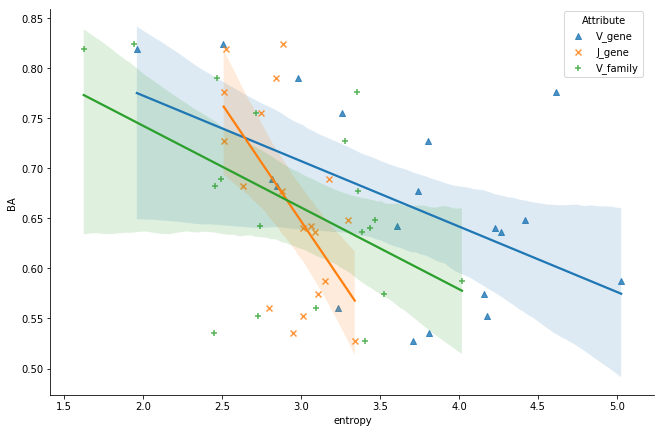

In [14]:
general = pd.DataFrame()
df = pd.DataFrame()
df['BA'] = performances
df['Attribute'] = 'V_gene'
df['entropy'] = entropies_Vgene
general = general.append(df)
df['Attribute'] = 'J_gene'
df['entropy'] = entropies_Jgene
general = general.append(df)
df['Attribute'] = 'V_family'
df['entropy'] = entropies_Vfamily
general = general.append(df)
fig = px.scatter(general, x="entropy", y="BA", trendline="ols",
                 color="Attribute",
                )
results = px.get_trendline_results(fig)
results.query("Attribute == 'V_gene'").px_fit_results.iloc[0].summary()


ax = sns.lmplot(x="entropy", y="BA", hue="Attribute",
                data=general, markers=['^', 'x', '+'])

ax.fig.set_figheight(6)
ax.fig.set_figwidth(12)
leg = ax._legend
leg.set_bbox_to_anchor([0.75,0.9])
leg.set_frame_on(True)
#ax.savefig(results_dir + 'trend_plot_entropy.png')

### Balanced accuracy violin plots

In [15]:
for epitope in ['RAKFKQLL', 'ELAGIGILTV', 'NLVPMVATV', 'GILGFVFTL']:
    results = pd.read_csv(results_dir + 'results_' + epitope + '.csv')
    voting_results = pd.read_csv(results_dir + 'votingresults_' + epitope + '.csv')
    
    results['true_type'] = results['training_type'] + results['threshold']
    results['true_type'] = results['true_type'].apply(lambda x: x.rstrip('_'))
    results['true_type'] = results['true_type'].str.replace('self_threshold','self_thr')
    results['true_type'] = results['true_type'].str.replace('supervised','super')
    
    voting_results['true_type'] = voting_results['training_type'] + voting_results['threshold']
    voting_results['true_type'] = voting_results['true_type'].apply(lambda x: x.rstrip('_'))
    voting_results['true_type'] = voting_results['true_type'].str.replace('self_threshold','self_thr')
    voting_results['true_type'] = voting_results['true_type'].str.replace('supervised','super')
    
    
    models = results['model'].unique()
    semi_types = ['super', 'self_thr0.5', 'self_thr0.6',
                  'self_thr0.7', 'self_thr0.8', 'self_thr0.9', 'self_thr0.95']
    genetic_types = ['super', 'super_noinfo', 'super_noV', 'super_noJ']
    for model in models:
        
        # SSL violin plot results
        fig = go.Figure()
        if model == 'VotingClassifier':
            res = voting_results[voting_results['model'] == model]
        else:
            res = results[results['model'] == model]
        
        print('SSL Balanced Accuracy for '+model+ ' '+epitope)
        for semi_type in semi_types:
            fig.add_trace(go.Violin(x=res['true_type'][res['true_type'] == semi_type],
                                    y=res['balanced_accuracy'][res['true_type'] == semi_type],
                                    name=semi_type,
                                    box_visible=False,
                                    points = 'all',
                                    pointpos = 0,
                                    meanline_visible=True))
            
        fig.update_layout(
                            xaxis_title='Training type',
                            yaxis_title='Balanced Accuracy',
                            showlegend = False,
                        )
        #fig.write_image(results_dir + 'SSLresults_BA_'+epitope+'_'+model + '.png', height=600, width=900, scale = 4)
        fig.show()
        
        # Genetic information violin plot results
        fig = go.Figure()
        if model == 'VotingClassifier':
            res = voting_results[voting_results['model'] == model]
        else:
            res = results[results['model'] == model]
        print('Gene Balanced Accuracy for '+model+ ' '+epitope)
        for genetic_type in genetic_types:
            fig.add_trace(go.Violin(x=res['true_type'][res['true_type'] == genetic_type],
                                    y=res['balanced_accuracy'][res['true_type'] == genetic_type],
                                    name=genetic_type,
                                    box_visible=False,
                                    points = 'all',
                                    #jitter = 0,
                                    pointpos = 0,
                                    meanline_visible=True))
            
        fig.update_layout(
                            xaxis_title='Training type',
                            yaxis_title='Balanced Accuracy',
                            #legend_title='Training type',
                            showlegend = False,
                        )

        fig.show()

SSL Balanced Accuracy for RandomForest RAKFKQLL
Gene Balanced Accuracy for RandomForest RAKFKQLL


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61800)
Traceback (most recent call last):
  File "/Users/fabio_air/anaconda3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/fabio_air/anaconda3/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/fabio_air/anaconda3/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/fabio_air/anaconda3/lib/python3.8/socketserver.py", line 720, in __init__
    self.handle()
  File "/Users/fabio_air/anaconda3/lib/python3.8/http/server.py", line 427, in handle
    self.handle_one_request()
  File "/Users/fabio_air/anaconda3/lib/python3.8/http/server.py", line 415, in handle_one_request
    method()
  File "/Users/fabio_air/anaconda3/lib/python3.8/site-packages

SSL Balanced Accuracy for GradientBoosting RAKFKQLL
Gene Balanced Accuracy for GradientBoosting RAKFKQLL
SSL Balanced Accuracy for ExtraTrees RAKFKQLL
Gene Balanced Accuracy for ExtraTrees RAKFKQLL
SSL Balanced Accuracy for KNN RAKFKQLL
Gene Balanced Accuracy for KNN RAKFKQLL
SSL Balanced Accuracy for LogisticRegression RAKFKQLL
Gene Balanced Accuracy for LogisticRegression RAKFKQLL
SSL Balanced Accuracy for VotingClassifier RAKFKQLL
Gene Balanced Accuracy for VotingClassifier RAKFKQLL
SSL Balanced Accuracy for RandomForest ELAGIGILTV


KeyboardInterrupt: 

### AUROC & AP boxplots

In [ ]:
semi_types = ['super', 'self_thr0.5', 'self_thr0.6',
                  'self_thr0.7', 'self_thr0.8', 'self_thr0.9', 'self_thr0.95']
genetic_types = ['super', 'super_noinfo', 'super_noV', 'super_noJ']
types = [
        semi_types,
        genetic_types
        ]
colors = ['#3366CC','#FF7F0E','#2CA02C','#7F7F7F']

for t in types:
    for measure in ['AUC', 'AP']:
        for model in ['RandomForest', 'GradientBoosting', 'ExtraTrees', 'KNN', 'LogisticRegression', 'VotingClassifier']:
            print('Model: ', model)
            fig = go.Figure()
            for i, epitope in enumerate([
                'RAKFKQLL', 'ELAGIGILTV',
                'NLVPMVATV',
                'GILGFVFTL']):
                results = pd.read_csv(results_dir + 'results_' + epitope + '.csv')
                voting_results = pd.read_csv(results_dir + 'votingresults_' + epitope + '.csv')

                results['true_type'] = results['training_type'] + results['threshold']
                results['true_type'] = results['true_type'].apply(lambda x: x.rstrip('_'))
                results['true_type'] = results['true_type'].str.replace('self_threshold','self_thr')
                results['true_type'] = results['true_type'].str.replace('supervised','super')
                results.drop(columns=['epitope', 'fold', 'brier_score', 'training_type', 'threshold'],inplace = True)
                results.rename(columns={'auc': 'AUC', 'avg_precision': 'AP', 'balanced_accuracy': 'BA'}, inplace=True)
                results = results[results['true_type'].isin(t)]
                
                voting_results['true_type'] = voting_results['training_type'] + voting_results['threshold']
                voting_results['true_type'] = voting_results['true_type'].apply(lambda x: x.rstrip('_'))
                voting_results['true_type'] = voting_results['true_type'].str.replace('self_threshold','self_thr')
                voting_results['true_type'] = voting_results['true_type'].str.replace('supervised','super')
                voting_results.drop(columns=['epitope', 'fold', 'brier_score', 'training_type', 'threshold'],inplace = True)
                voting_results.rename(columns={'auc': 'AUC', 'avg_precision': 'AP', 'balanced_accuracy': 'BA'}, inplace=True)
                voting_results = voting_results[voting_results['true_type'].isin(t)]
                
                if model == 'VotingClassifier':
                    res = voting_results[voting_results['model'] == model]
                else:
                    res = results[results['model'] == model]
                fig.add_trace(
                    go.Box(
                    x=res['true_type'],
                    y=res[measure], 
                    line=dict(color=colors[i]),
                    name=epitope,
                ))
            fig.update_layout(
                    boxmode='group',
                    yaxis_title=measure,
                    xaxis_title='Training types',
            )
            #fig.write_image(results_dir + 'SSLresults_'+measure+'_'+model + '.png', height=600, width=900, scale = 4)
            fig.show()

### Brier loss data

In [ ]:
semi_types = ['super','self_thr0.5', 'self_thr0.6', 'self_thr0.7', 'self_thr0.8', 'self_thr0.9', 'self_thr0.95']
for epitope in ['RAKFKQLL', 'ELAGIGILTV', 'NLVPMVATV', 'GILGFVFTL']:
    print('Epitope: ', epitope)
    results = pd.read_csv(results_dir + 'results_' + epitope + '.csv')
    voting_results = pd.read_csv(results_dir + 'votingresults_' + epitope + '.csv')

    results['true_type'] = results['training_type'] + results['threshold']
    results['true_type'] = results['true_type'].apply(lambda x: x.rstrip('_'))
    results['true_type'] = results['true_type'].str.replace('supervised','super')
    results['true_type'] = results['true_type'].str.replace('self_threshold','self_thr')
    results.drop(columns=['epitope', 'fold', 
                          'auc',
                          #'avg_precision',
                          'balanced_accuracy',
                          'brier_score',
                          'training_type', 'threshold'],inplace = True)
    results = results[results['true_type'].isin(semi_types)]
    res = results.groupby(['model','true_type'], as_index=False).agg([np.mean, np.std])
    print(res)